In [10]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from lenstronomy.Util.correlation import *
from galsim import InterpolatedImage, Image

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs, psf

In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

In [3]:
from mejiro.lenses import lens_util
detectable_lenses = lens_util.get_detectable_lenses(pipeline_dir, with_subhalos=False)
print(f'Number of detectable lenses: {len(detectable_lenses)}')

100%|██████████| 18/18 [00:00<00:00, 37.39it/s]

Number of detectable lenses: 190


In [4]:
survey_params = util.hydra_to_dict(config.survey)
snr_band = survey_params['snr_band']
snr_num_pix = survey_params['snr_num_pix']
snr_side = survey_params['snr_side']
snr_oversample = survey_params['snr_oversample']

Loading cached PSF: /nfshome/bwedig/mejiro/mejiro/data/cached_psfs/F129_1_2048_2048_1.pkl


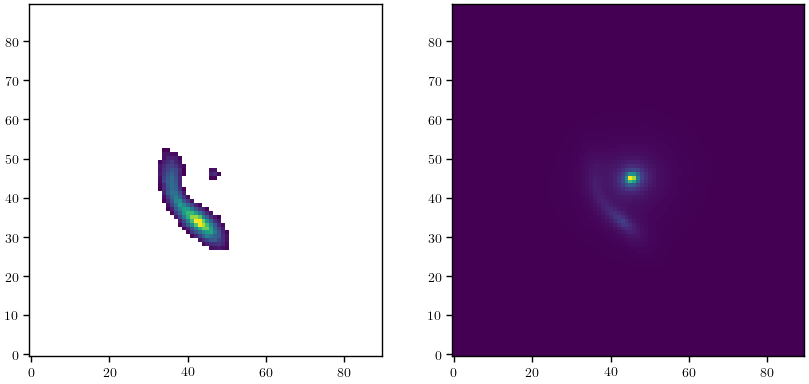

In [5]:
sample_lens = np.random.choice(detectable_lenses)

# generate and add subhalos
realization = sample_lens.generate_cdm_subhalos()
sample_lens.add_subhalos(realization)

# get synthetic image
model = sample_lens.get_array(snr_num_pix * snr_oversample, snr_side, snr_band)

# load the PSF kernel
psf_id_string = psf.get_psf_id_string(band=snr_band, detector=1, detector_position=(2048, 2048), oversample=snr_oversample)
psf_kernel = psf.load_cached_psf(psf_id_string)

# simulate image
total_flux_cps = sample_lens.get_total_flux_cps(snr_band)
interp = InterpolatedImage(Image(model, xmin=0, ymin=0), scale=0.11 / snr_oversample, flux=total_flux_cps * 146)
image = gs.convolve(interp, psf_kernel, snr_num_pix)
total = image.array * 146

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_lens.masked_snr_array)
ax[1].imshow(total)
plt.show()

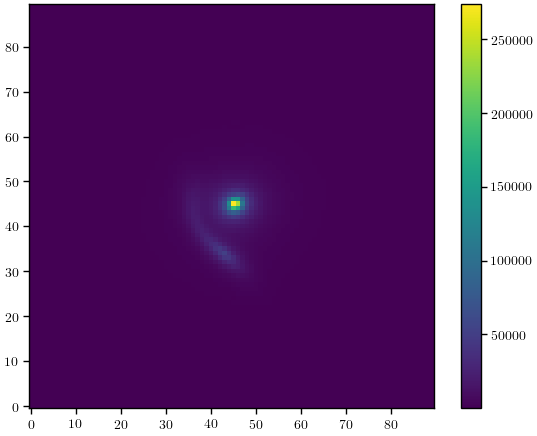

In [6]:
plt.imshow(total)
plt.colorbar()
plt.show()

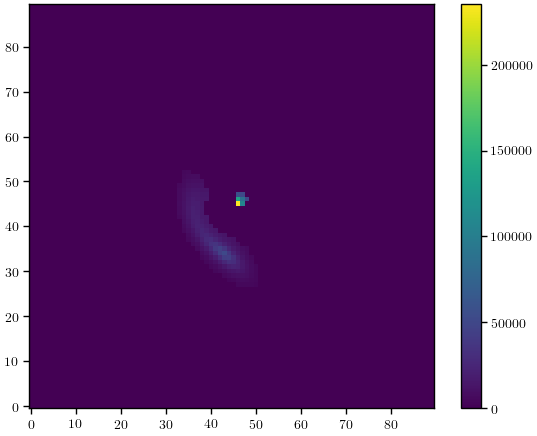

In [7]:
# get mask from snr array
mask = np.ma.getmask(sample_lens.masked_snr_array)

# apply mask to total image
total_masked = np.ma.masked_array(total, mask)

# convert to array with fill value 0
np.ma.set_fill_value(total_masked, 0)
masked_array = total_masked.filled()

plt.imshow(masked_array)
plt.colorbar()
plt.show()

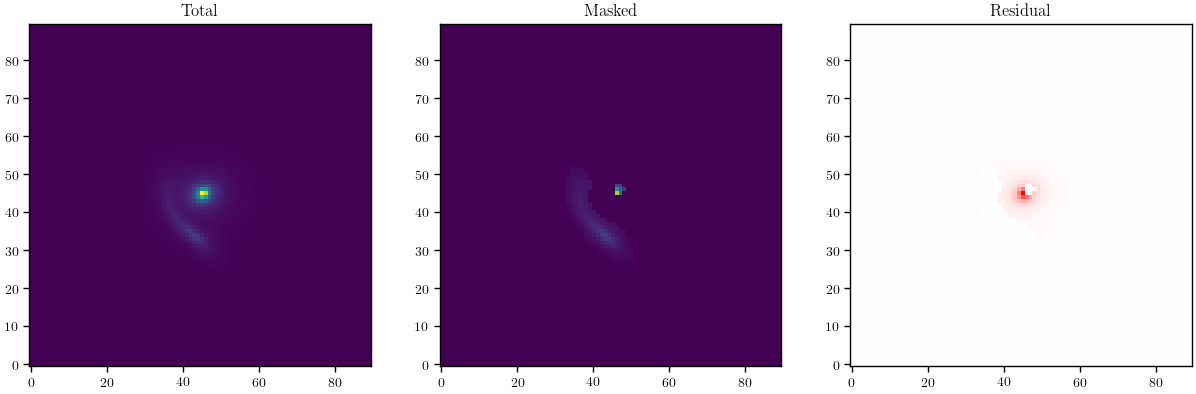

In [8]:
_, ax = plt.subplots(1, 3, figsize=(15, 5))

vmin = np.min(total)
vmax = np.max(total)

residual = total - masked_array
res_v = np.max(np.abs(residual))

ax[0].imshow(total, vmin=vmin, vmax=vmax)
ax[1].imshow(masked_array, vmin=vmin, vmax=vmax)
ax[2].imshow(residual, cmap='bwr', vmin=-res_v, vmax=res_v)

ax[0].set_title('Total')
ax[1].set_title('Masked')
ax[2].set_title('Residual')

plt.show()

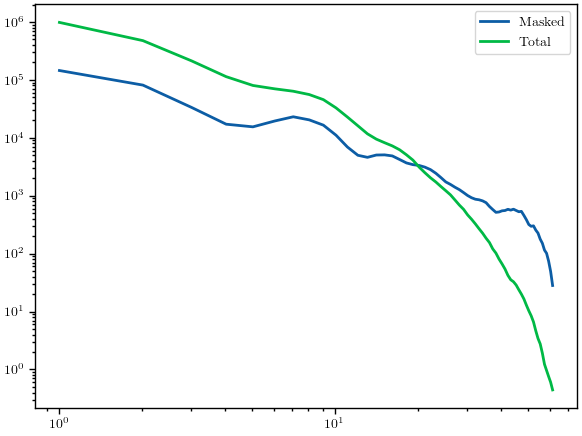

In [11]:
masked_power_spectrum, masked_r = power_spectrum_1d(masked_array)
power_spectrum, r = power_spectrum_1d(total)

plt.loglog(masked_r, masked_power_spectrum, label='Masked')
plt.loglog(r, power_spectrum, label='Total')
plt.legend()
plt.show()

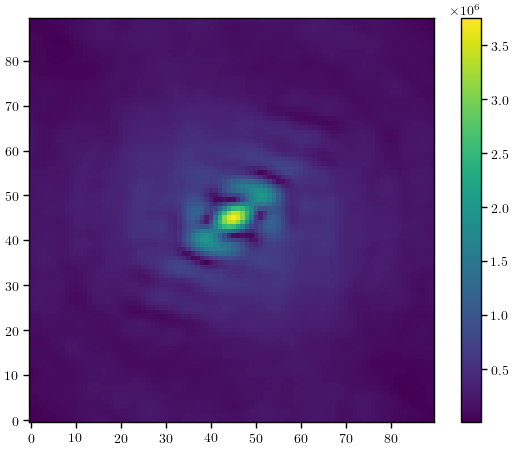

In [13]:
plt.imshow(correlation_2D(masked_array))
plt.colorbar()
plt.show()

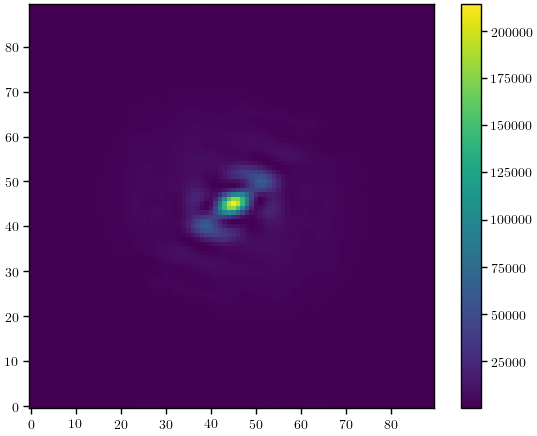

In [12]:
plt.imshow(power_spectrum_2d(masked_array))
plt.colorbar()
plt.show()